# Part 1
## MITF-low, Keratin, Immune
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/

In [1]:
import os

# import some data from my github
# might take a while
if "bg" not in os.listdir(os.getcwd()):
    os.system("git clone https://github.com/AfasRob/bg")

In [2]:
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from numpy import mean, std

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc
from bg.consensusClustering import ConsensusCluster

warnings.simplefilter("ignore")

In [3]:
# Read data files

diff_expr = pd.read_csv("bg/data_mrna_seq_v2_rsem.txt", sep='\t', lineterminator='\n').set_index('Hugo_Symbol')
z_scores = pd.read_csv("bg/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep='\t', lineterminator='\n')

In [4]:
how_much_top_variant_genes_to_analyse = 1246  # how much genes u want

# block for extracting 1500 most varient expression levels
genes_1500_diff_table = diff_expr.iloc[:,1:]

# keep genes which are observed in at least 50% of the samples
genes_1500_diff_table = genes_1500_diff_table.replace(0,np.NaN).dropna(thresh=236).replace(np.NaN,0)

# calculate variance of genes
genes_1500_diff_table['variant'] = genes_1500_diff_table.apply(lambda x: std(x) / mean(x), axis=1)
genes_1500_sorted = genes_1500_diff_table.sort_values(by=['variant'], ascending=False)
# get top genes list
genes_1500_list = list(genes_1500_sorted.index.values)[:how_much_top_variant_genes_to_analyse]  # 1246 + 254 from paper (sets are partially intersecting)

In [5]:
# Supplemental Table S4A genes
genes_paper = """
CD1C, CD2, CD3E/D/G, CD6, CD7, CD8A/B, CD19, CD20, CD79A/B, NKG7, KLRD1, 
KLRC1, KIR2DL4 CD24, CD38 SH2D1A, TIGIT, PTPRCAP, LAX1, SPIB, SLAMF1 TCL1A, 
TRAT1, THEMIS, LCK, SIT1, HSH2D, ITK, PTPRC, ZAP70, CRTAM, TIMD4, SIRPG, SLA2, 
DC247, TBX21, RHOH, HSH2D POU2AF1, BLK, PAX5, BANK1, STAP1, IKZF3, TNFRSF17, 
MS4A1, SPIB AIM2, SKAP1, IFI27, NLRP2, ZBP1, TIBAB GZMA/B/H/K, CHIT1, MMP12, HAMP, 
ERAP2, MARCO, GBP5, SLAMF6, KLRK1, LILRA4, SLAMF7, CHI3L1 TNFRSF9, CD27 PDCD10 PDCD11 PDCD1LG2 LAG3, 
BTLA IFNG, FDCSP, CXCL9 CXCL10 CXCL11 CXCL13 CCL7 CCL19 CCL21, XCL1/2, CCR4, CXCR3/5, DARC, IL7R, IL21R, 
IL22RA2 MAGEA1 MAGEA4 MAGEA10 MAGEA11 MAGEB2 MAGEC1 MAGEC2 CTAG1B CTAG2, CT12.1  CT16.1  CT44  CT55  CT115 OCA2, 
DCT, TYRP, CDH1, CDH3, CDH7, DAPL1, GABRA5 GABRB3, ADCY2, GNAL, BRSK2, CNTFR, BCAN, SHANK1, SNAP25, 
BEX1, SNCB, CHRNA7, HAP1, AP3B2, VSNL1 POU3F1 POU4F1, DPYSL4/5, VGF, L1CAM, EFHD1, NKX2-2, DLX6, SOX1, 
OLFM1, NTN1, NEUROG2, COBL IRX1/2, GATA4/5, HES2, PITX1/2, ISL1, LMX1B, FOXF2, LHX2 KRT1, KRT5, 
KRT6A/B/C, KRT14, KRT16, KRT17, KRT78, KRT80, DAP KRT4, KRT13, KRT15, KRT19, KRT23, KRT27, KRT75, 
KRT79, KRTAP19-1 KLK7, KLK11 KLK4, KLK5, KLK8, KLK10, KLK11, KLK13, SPRR1A SPRR2E, LOR, EVPL, SFN, 
SERPINB13 PPL, RPTN, CALML5, SPINK5, SPRR1B SPRR2A SPRR2B SPRR2G SPRR2D SPRR2F SPRR3, LGALS7, S100A7, 
IVL, SFN, CDSN, LOR, FOXN1, SCEL, OVOL1, FERM1, BNC1, EHF TYRP1, DCT, KIT, TRPM1, CDKN2A, GZMB, GAPDHS, 
CA14, HPGD, KCNN2, MCOLN3, PLA1A, BCAN, SLC16A6, ABCC2, FXYD3, SCUBE2, LDB3, PSCA AKR1C2, FABP7, ACOX2 GABRA2 GABRG2 GABRR1 GABRP GABRQ, 
NCAM1/2, GFRA1/3, OLIG1/2, BAI1/3, DNER, NRXN3, MAG, NTS, RTN4RL1, AQP4, CHRNB2, PMP2, MPZ, BDNF, GAD1, CNTNAP3, 
CDH2, SLITRK5, ISL2, MOG, FABP7, CNR, PPP1R1B, GLRB, GRIK3, NPTX2, GRIA2, GAP43, LPPR1, NDRG4, APLP1, NPTXR, NOVA1, 
NGEF, LRFN5, ENPP5, ENTPD2, 
MT3 PCDHA2 PCDHA3 PCDHA6 PCDHA7 PCDHA11 PCDHA12 PCDHA13 PCDHB2 PCDHB5 PCDHB6 PCDHB16 PCDHB17 PCDHAC1 PCDHAC2 PCDHH20, 
RELN, ODZ1/3, POU3F3 POU6F2, TRIM71, FEZF1, FRMPD4, GPR98, LRRTM4, CHRDL1, SLITRK6, GPC4, GDNF, ALDH1A3, 
ECRG4, SDK2, ZNF711, NFASC, MAB21L1, ASTN1, DOK5, RBM11, LIFR, SOX2 SOX11, 
HOXA7 HOXB9 HOXB13 HOXC12 HOXD13, FOXA3 FOXP2, CNTN3/4/6, NRG1, SMOC1, DLK1, SHISA2, DCDC2, TFAP2C, SALL1, MEOX2, EYA1, HAND2, 
TLX1/2 ABCB5, MS4A1 CXCL1/5/6, CCL20, IL11, KCNN4, REG3G, SPP1, RORC, 
GBP7 MAGEA1 MAGEA4 MAGEA5 MAGEA10 MAGEA11 MAGEB1 MAGEB2 MAGEC1 MAGEC2 MAGED4 MAGED4B CTAG1B CTAG2, PAGE1/5, 
BAGE, XAGE1D, CXORF48 CT55, ANKRD45 CT117 DNAH2 DNAH9 DNALI1, SEMA3A SEMA3E, KANK4, RHOD, STK33, FSD1, ARC, 
COCH, RND2ARHGEF16, EFS LOXL3/4, ITIH5, ADAMTS3 ADAMTS20, VIT, MMP16, LEPREL1
"""

In [6]:
# get gene list from Supplemental Table S4A
gene_list = genes_paper.split(" ")
replace_chars = [",", "\n", "\\", " "]
for char in replace_chars:
    gene_list = [s.replace(char, "") for s in gene_list]
divide_gene = []
for full_gene in gene_list:
    if "/" in full_gene:
        gene_split = full_gene.split("/")
        base_gene = gene_split[0][:-1]
        divide_gene.append(gene_split[0])
        if all(len(x)==1 for x in gene_split[1:]):
            to_append = [base_gene+gn for gn in gene_split[1:]]
        else:
            print(f"Not single gene: {full_gene}")
        divide_gene.extend(to_append)
    else:
        divide_gene.append(full_gene)

In [7]:
# append genes from paper to our list        
lost_genes_from_paper = []
for gene in divide_gene:
    if gene in genes_1500_list:
        continue
    elif gene in z_scores["Hugo_Symbol"].to_list():
        genes_1500_list.append(gene)  # comment here if u DONT want to see paper genes in top varient 1500
    else:
        lost_genes_from_paper.append(gene)

We lost 50 genes from paper because we dont have such gene names in our data

In [8]:
# get df for these 1500 genes
z_scores_1500 = z_scores[z_scores["Hugo_Symbol"].isin(genes_1500_list)]
z_scores_1500 = z_scores_1500.iloc[:,2:].T

In [ ]:
# trying ConsensusCluster for data
data = np.array(z_scores_1500)

# used 4 clusters because this way we can select 3 subclusters from a huge undivided cloud
kmeans_=KMeans
cc = ConsensusCluster(cluster=kmeans_, L=4, K= 5, H=100) 
cc.fit(data, verbose = False)
cc.predict()
clust_values = cc.predict_data(data)
clust_values # got labels

In [ ]:
# make a kind of unsorted confusion matrix to check if the classification is correct

# my_clusters from consensusClustering in dict for confusion matrix
my_clusters = dict(zip(list(z_scores_1500.index.values),clust_values))

# get clusters from the paper to dict for confusion matrix
known_cluster_table = pd.read_excel("bg/NIHMS698912-supplement-3.xlsx",sheet_name="Supplemental Table S1D",header=1)
known_cluster_dict = dict(zip(known_cluster_table["Name"], known_cluster_table["RNASEQ-CLUSTER_CONSENHIER"]))

# confusion matrix
df = pd.DataFrame({'keratin': [0, 0, 0, 0],
                   'immune': [0, 0, 0, 0],
                   'MITF-low': [0, 0, 0, 0],
                   '-': [0, 0, 0, 0],
                  }, index=['0','1','2','3'])
for sample in known_cluster_dict.items():
    if sample[0] in my_clusters.keys():
        df.iloc[my_clusters[sample[0]]][sample[1]] += 1
        
df

It doesn't look good. At least we get 3 sub-clusters that look like parts of paper clusters. Let's try the hierarchical clustering method

In [ ]:
# hierarchical clustering
selected_data = pd.DataFrame(z_scores_1500,columns = z_scores_1500.columns) 
clusters = shc.linkage(
    selected_data,
    method='ward', 
    metric="euclidean"
)

n = 472 # samples
k = 3 # number of clusters
T = shc.fcluster(clusters, k, 'maxclust')

# get labels
labels=list('' for i in range(n))
for i in range(n):
    labels[i]=str(i)+ ',' + str(T[i])
ct=clusters[-(k-1),2]

In [ ]:
# get data for confusion matrix
dendro_order = []
for sample in shc.dendrogram(Z=clusters, get_leaves=True)['leaves']:
    if sample <= 332:
        dendro_order.append(known_cluster_table["Name"][sample])
    else:
        dendro_order.append("-")
my_clusters = dict(zip(dendro_order, shc.dendrogram(Z=clusters,labels=labels,color_threshold=ct)['leaves_color_list']))
# check if the classification is correct
df = pd.DataFrame({'keratin': [0, 0, 0, 0],
                   'immune': [0, 0, 0, 0],
                   'MITF-low': [0, 0, 0, 0],
                   '-': [0, 0, 0, 0],
                  }, index=['C0','C1','C2','C3'])
for sample in known_cluster_dict.items():
    if sample[0] in my_clusters.keys():
        df.loc[my_clusters[sample[0]]][sample[1]] += 1
df

Okay, it is getting worse. 
PCA + Kmeans will show if there are clusters at all

In [ ]:
# PCA
data_scaled = pd.DataFrame(z_scores_1500,columns = z_scores_1500.columns) 
pca = PCA(n_components=3)
pcs = pca.fit_transform(data_scaled)

# PCA plot
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values)

# explained_variance_ratio_ plt
plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = [str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = labels)
plt.show()

explained_variance_ratio is bad

In [ ]:
model = KMeans(n_clusters = 4, init = "k-means++")
label = model.fit_predict(pcs)
centers = np.array(model.cluster_centers_)

plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(pcs[label == i , 0] , pcs[label == i , 1] , label = i)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
plt.legend()
plt.show()

In [ ]:
# Сonfusion matrix 
my_clusters = dict(zip(z_scores_1500.index.values,label.tolist()))

df = pd.DataFrame({'keratin': [0, 0, 0, 0],
                   'immune': [0, 0, 0, 0],
                   'MITF-low': [0, 0, 0, 0],
                   '-': [0, 0, 0, 0],
                  }, index=['0','1','2','3'])

for sample in known_cluster_dict.items():
    if sample[0] in my_clusters.keys():
        df.iloc[my_clusters[sample[0]]][sample[1]] += 1
sns.heatmap(df, annot=True)

obviosly, F1 scores are bad (as above)


we catch some of keratin cluster (f1=0,43), half of immune cluster (f1=0.34), kind of mitf low cluster (f1=0.36) and one big undivided cluster

# Part 2
## Pigmentation, Proliferative, Normal-like, High-immune response
## https://aacrjournals.org/clincancerres/article/16/13/3356/11021/Gene-Expression-Profiling-Based-Identification-of

In [ ]:
# genes from paper sup files
paper_genes = [
    'FCHSD2', 'TBC1D7', 'MBNL1', 'RASGRP2', 'MARVELD2', 
    'CDO1', 'TIE1', 'STK32A', 'GZMK', 'C20orf20', 'C12orf5', 
    'PLXNC1', 'APOO', 'SORT1', 'STX1A', 'SDPR', 'ZNF789', 'MREG', 
    'SOCS6', 'AKR1C3', 'ZNF343', 'SDCBP', 'LYST', 'KIAA1522', 
    'SH2D3C', 'TUFT1', 'CDK2', 'ICAM2', 'IRF4', 'ANKRD47', 'DHRS3', 
    'TSPAN10', 'EDNRB', 'MYO5A', 'BOP1', 'CCDC69', 'SLC4A3', 'SLC3A2', 
    'PRKCB1', 'STAB1', 'DNAH2', 'MGC13057', 'RORA', 'TMEM79', 'PTPLA', 
    'GPR180', 'SMOX', 'DENND2C', 'TIMP2', 'TEK', 'VWF', 'TTYH2', 'GADD45B', 
    'FOXD1', 'PGM5', 'FZD4', 'DLX1', 'TGDS', 'EDG1', 'EDG6', 'SLC24A5', 'LAD1', 
    'IQGAP2', 'FOXO4', 'IRX2', 'SH3GLB2', 'C13orf15', 'RGS20', 'SLC25A26', 'CCND2', 
    'SASP', 'ST6GALNAC2', 'EPS8L1', 'STXBP1', 'DTD1', 'GPR143', 'ARHGAP30', 'NKG7', 
    'TYR', 'AADAT', 'DLG4', 'VNN2', 'SLC45A2', 'MRPL44', 'ANKRD29', 'CXCL12', 'DERA', 
    'GJA4', 'RABIF', 'MAP3K8', 'IL10RA', 'AOC3', 'PTK2B', 'PHACTR1', 'KLF5', 'GIMAP6', 
    'FILIP1', 'SCG2', 'HNMT', 'DCT', 'BTNL9', 'HLA-B', 'LYL1', 'SDC1', 'BNIPL', 'ERCC1', 
    'RASGRP3', 'STARD5', 'TAPBP', 'KRT10', 'CLTB', 'HOP', 'MARS2', 'SYNGR1', 'LCK', 
    'PTGDS', 'SPRY2', 'SP140', 'APBB1IP', 'IL3RA', 'C5orf22', 'CHCHD6', 'PRMT1', 'IMPA2', 
    'TNFRSF1B', 'CD19', 'SOX13', 'CLIC3', 'GIMAP1', 'CPA2', 'GPNMB', 'HLA-DRB1', 'KRT31', 
    'SLC9A5', 'FRAG1', 'SLC9A9', 'CLDN5', 'TMEM154', 'TMEM166', 'ATP8B4', 'DST', 'CDS1', 
    'RAPGEFL1', 'GAB3', 'PPFIBP1', 'MDM2', 'MLLT11', 'STARD10', 'C1orf106', 'IL33', 'NINJ1', 
    'BMP2K', 'CAMK2N1', 'MYOM1', 'ITPA', 'GIMAP7', 'FLJ38482', 'IKZF1', 'TGFBR2', 'CTNNBIP1', 
    'PLCL2', 'SNCA', 'CTSL2', 'CNFN', 'UNC5CL', 'LOC728069', 'EDNRB', 'PAX3', 'TGFBR3', 'INPP4B', 
    'FLI1', 'MLANA', 'FGFR3', 'ANKRD39', 'RSPO3', 'DPT', 'PDK4', 'LYPD3', 'TAGLN', 'TUBB4', 'OPTN', 
    'C1orf85', 'IFT81', 'PPP1R13L', 'ARHGAP24', 'GGTLA1', 'STX7', 'CXADR', 'CCL15', 'SYT15', 'GMPR', 
    'TLR1', 'CD3E', 'WWTR1', 'LOC441376', 'BSPRY', 'ALDH3B2', 'CCDC120', 'PKNOX2', 'PAX3', 'CYP46A1', 
    'C12orf24', 'RAD51C', 'TMEM176A', 'UBL3', 'SLC7A5', 'DARC', 'PCDH7', 'STAP2', 'MOSPD1', 'BANK1', 
    'MFNG', 'LOC338328', 'JUP', 'ADCY4', 'WDFY1', 'MGC23985', 'ANKRD28', 'EPAS1', 'ANXA5', 'REP15', 
    'SDCBP2', 'IL20RB', 'GIMAP4', 'CABLES1', 'GIMAP5', 'TMEM14B', 'C6orf218', 'OAS1', 'EGLN3', 'CASZ1', 
    'PROM2', 'TRIM63', 'SLC40A1', 'GBP4', 'TDRD7', 'EBF1', 'PAX3', 'BTK', 'SPINT2', 'C20orf160', 
    'C9orf95', 'CYP4F12', 'ZNF202', 'KCNG1', 'MYO10', 'FILIP1L', 'LAX1', 'RCSD1', 'PCID2', 'GMFG', 
    'DMKN', 'RFTN1', 'NOTCH4', 'TMEM134', 'USP48', 'SLC45A2', 'HLA-DQB1', 'PTGS1', 'FZD8', 'TMEM45A', 
    'IFIH1', 'GLTP', 'LGALS7', 'GCNT2', 'CDK6', 'LOC650919', 'LOC646064', 'GSTO2', 'B3GALT4', 'GPR116', 
    'EXOC2', 'PPM1H', 'RGAG4', 'SNCA', 'KIAA1345', 'KRT80', 'SACS', 'LOC646675', 'LOC388564', 'LOC650803', 
    'AP1S2', 'MIR16', 'ADD3', 'LOC284023', 'FLJ90086', 'CTH', 'GPSM1', 'LOC730063', 'MMD', 'H2AFZ', 
    'LTB4R', 'DOCK11', 'C6orf189', 'SHANK3', 'ERRFI1', 'MITF', 'LOC641700', 'PERP', 'GNB3', 'HLA-DPB1', 
    'IFI35', 'PDE1B', 'SNRPB2', 'LMO2', 'CBS', 'COL17A1', 'ZNF273', 'SCN4A', 'REM1', 'KRT17', 'PIGY', 
    'C3', 'ACVRL1', 'SCNN1A', 'C10orf57', 'GPR34', 'MBNL2', 'EBI2', 'ACSL5', 'C4orf34', 'ZFP106', 'PLVAP', 
    'DEGS1', 'CDH5', 'PPL', 'PCSK5', 'CA4', 'PTGER2', 'MAP7', 'ZNF185', 'GIMAP8', 'SLAMF7', 'FBXW7', 
    'ARRDC2', 'LAD1', 'SELP', 'PECAM1', 'SPRR1A', 'POFUT1', 'NCF4', 'SLC16A4', 'FAM110A', 'CCL16', 
    'KLK10', 'CAMK2B', 'GALNAC4S-6ST', 'PTPRH', 'SH2D3C', 'HSF2BP', 'BCAS3', 'OSBPL9', 'D4S234E', 'S100A13', 
    'TSNAX', 'P2RY13', 'SILV', 'ASB9', 'ZNF366', 'TRIM29', 'ELOVL4', 'LRMP', 'SGCD', 'KLF2', 'ICOS'
]

# get these genes from our tablet to df
lost_genes_from_paper = []
genes_list = []
for gene in paper_genes:
    if gene in z_scores["Hugo_Symbol"].to_list():
        genes_list.append(gene)
    else:
        lost_genes_from_paper.append(gene)
z_scores_294 = z_scores[z_scores["Hugo_Symbol"].isin(genes_list)]
z_scores_294 = z_scores_294.iloc[:,2:].T
print(len(lost_genes_from_paper))

## So, we lost 71 out of 365 genes, again.

In [ ]:


data_scaled_2 = pd.DataFrame(z_scores_294,columns = z_scores_294.columns) 
pca_2 = PCA(n_components=3)
pcs_2 = pca_2.fit_transform(data_scaled_2)

pc1_values_2 = pcs_2[:,0]
pc2_values_2 = pcs_2[:,1]
sns.scatterplot(x=pc1_values_2, y=pc2_values_2)

plt.figure()
var_2 = np.round(pca_2.explained_variance_ratio_*100, decimals = 1)
labels_2 = [str(x) for x in range(1,len(var_2)+1)]
plt.bar(x=range(1,len(var_2)+1), height = var_2, tick_label = labels_2)
plt.show()

model_2 = KMeans(n_clusters = 4, init = "k-means++")
label_2 = model_2.fit_predict(pcs_2)
centers_2 = np.array(model_2.cluster_centers_)

uniq_2 = np.unique(label_2)
for i in uniq_2:
   plt.scatter(pcs_2[label_2 == i , 0], pcs_2[label_2 == i , 1] , label = i)
plt.scatter(centers_2[:,0], centers_2[:,1], marker="x", color='k')
plt.legend()
plt.show()

Feel like better then first paper results

# Part 3

## Какая из классификаций лучше разделяет пациентов по группам риска? Как вы думаете почему?

Статья 1
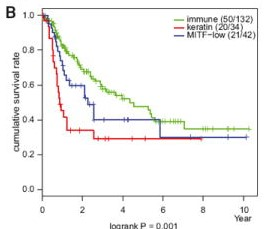
Статья 2
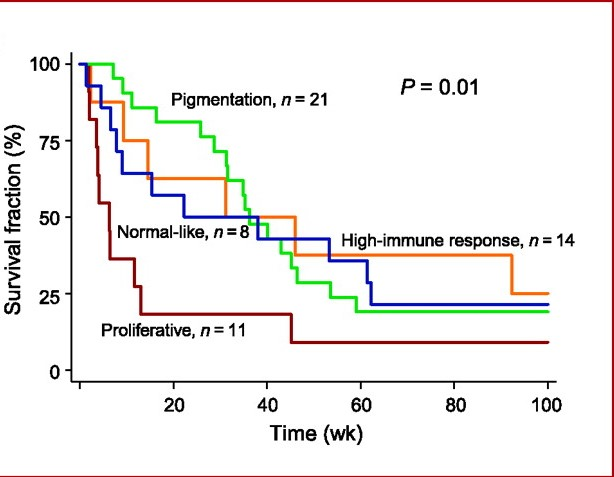 

## Кривые выживаемости Kaplan-Meier для статьи 1 (слева) и статьи 2 (справа)

Для начала, в статье справа все больные болеют 4 стадией меланомы, тогда как в левой статье представлены разные стадии. Не думаю, что сравнивать такие датасеты разумно, но всё же.


Как видно из графиков, кривые выживаемости справа падают намного быстрее, чем слева (обратите внимание на оси, они разной размерности). Причина этого (как минимум, отчасти) - разность стадий меланомы в датасетах. Так же, кривые кластеров Normal-like и High-immune response (синяя и оранжевая) лежат очень близко, что говорит о плохом разделении данных кластеров по выживаемости.


Пациенты тем лучше разделены, чем дальше кривые друг от друга, кривые в статье слева разделены лучше.

##  Какая из классификаций лучше отражает биологию опухолей? Почему? Какую из классификаций вы бы взяли для работы и почему?
Я спросил бы у более опытных коллег, которые лучше понимают биологию опухолей.


Если бы меня пытали с целью получить ответ: левая статья свежее + импакт у неё выше
(clin cancer res impact factor 2010 = **7.338(правая)**, cell impact factor 2015 = **22.387(левая)**)

## Описать полученный результат. Получилось ли у вас воспроизвести результаты авторов? 

Скорее не получилось, результаты keratin cluster (f1=0,43), half of immune cluster (f1=0.34) and kind of mitf low (f1=0.36) далеки от идеала.
## Почему?
у меня есть несколько идей:

1. Как минимум, коллеги использовали другой набор генов. Мой топ 1500 по coefficient of variation не сходится с их генами из Supplemental Table S4A (пересекается, но не входит).
2. Коллеги как-либо отфильтровали гены
3. Некоторые гены из статей отсутствуют в моих образцах (жаль что коллеги не записали Gene_Id)
4. Я сделал что-то фундаментально не правильно